In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

import nengo
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import BasicVecFeed, meg_from_spikes, make_alt_vocab

# Try choosing encoders in two dimensions

In [2]:
n_neurons = 100
p_neg = 25

vec_1 = [-1, -1]
vec_2 = [1, 1]

encoders = np.ones((n_neurons, 2))
encoders[:p_neg] = encoders[:p_neg] * -1

In [3]:
with nengo.Network() as model:
    ens = nengo.Ensemble(n_neurons, 2, encoders=encoders)

In [4]:
sim = nengo.Simulator(model)

Building finished in 0:00:01.                                                                                           


In [5]:
samples = 50

In [6]:
input_1 = -1*np.ones((samples, 2)) + np.random.uniform(size=(samples, 2))*0.1

In [7]:
input_2 = np.ones((samples, 2)) + np.random.uniform(size=(samples, 2))*0.1

In [8]:
input_1.shape

(50, 2)

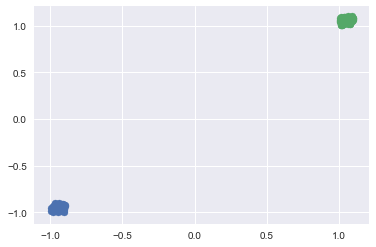

In [9]:
plt.scatter(input_1[:, 0], input_1[:, 1])
plt.scatter(input_2[:, 0], input_2[:, 1])

In [10]:
_, activity_1 = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=input_1)

In [11]:
_, activity_2 = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=input_2)

In [12]:
columns = ("vec", "resp")

a1 = activity_1.flatten()
l1 = ["v1"] * len(a1)
p1 = pd.DataFrame({"vec": l1, "resp": list(a1)})


a2 = activity_2.flatten()
l2 = ["v2"] * len(a2)
p2 = pd.DataFrame({"vec": l2, "resp": list(a2)})

acts = pd.concat((p1, p2))

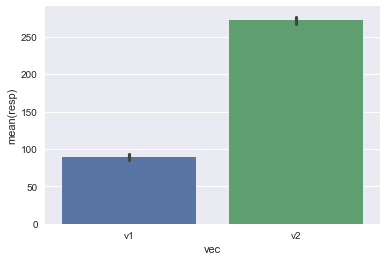

In [13]:
sns.barplot(x="vec", y="resp", data=acts)

# Apply to full vocab

In [17]:
dimensions = 64
n_neurons = 1000
seed = 8
p_fan = 0.9

In [18]:
vocab, fan1, fan1_vecs, fan2, fan2_vecs, foil1, foil1_vecs, foil2, foil2_vecs = make_alt_vocab(11, 11, dimensions, seed, norm=True)

In [19]:
encoders = np.zeros((n_neurons, dimensions))

fan1_end = int(n_neurons * p_fan)
print(fan1_end)

for n_i in range(fan1_end):
    encoders[n_i] = fan1_vecs[n_i % len(fan1)] + np.random.uniform(size=dimensions)*0.1
print(n_i)

for n_i in range(fan1_end, n_neurons):
    encoders[n_i] = fan2_vecs[n_i % len(fan2)] + np.random.uniform(size=dimensions)*0.1

print(n_i)

900
899
999


In [20]:
with nengo.Network() as model:
    ens = nengo.Ensemble(n_neurons, dimensions, encoders=encoders)

In [21]:
sim = nengo.Simulator(model)

Building finished in 0:00:01.                                                                                           


In [22]:
_, activity_1 = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=np.array(fan1_vecs))

In [23]:
_, activity_2 = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=np.array(fan2_vecs))

In [24]:
columns = ("vec", "resp")

a1 = activity_1.flatten()
l1 = ["fan1"] * len(a1)
p1 = pd.DataFrame({"vec": l1, "resp": list(a1)})


a2 = activity_2.flatten()
l2 = ["fan2"] * len(a2)
p2 = pd.DataFrame({"vec": l2, "resp": list(a2)})

acts = pd.concat((p1, p2))

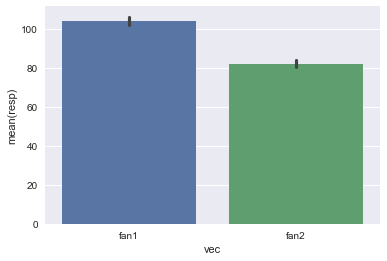

In [25]:
sns.barplot(x="vec", y="resp", data=acts)

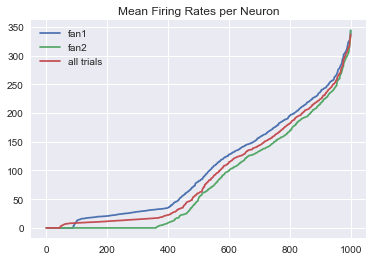

In [26]:
plt.title("Mean Firing Rates per Neuron")
plt.plot(np.sort(np.mean(activity_1, axis=0)), label="fan1")
plt.plot(np.sort(np.mean(activity_2, axis=0)), label="fan2")
plt.plot(np.sort(np.mean(np.concatenate((activity_1, activity_2)), axis=0)), label="all trials")
plt.legend()

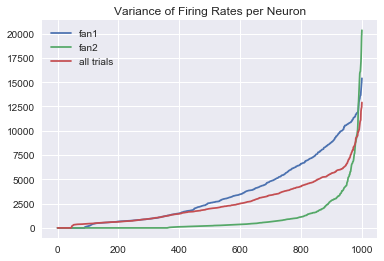

In [27]:
plt.title("Variance of Firing Rates per Neuron")
plt.plot(np.sort(np.var(activity_1, axis=0)), label="fan1")
plt.plot(np.sort(np.var(activity_2, axis=0)), label="fan2")
plt.plot(np.sort(np.var(np.concatenate((activity_1, activity_2)), axis=0)), label="all trials")
plt.legend()

Number of neurons basically firing for both vectors
49


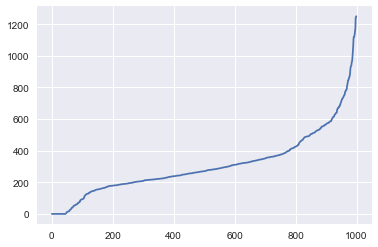

In [28]:
print("Number of neurons basically firing for both vectors")
fire_diff = np.sort(np.abs(np.sum(activity_1, axis=0) - np.sum(activity_2, axis=0)))
print(len(fire_diff[fire_diff < 10]))
plt.plot(fire_diff)

In [29]:
print("Number of neurons basically not firing for either vector")
fire_diff = np.sort(np.abs(np.sum(activity_1, axis=0) + np.sum(activity_2, axis=0)))
len(fire_diff[fire_diff < 10])

Number of neurons basically not firing for either vector


45

# Apply to mean vecs

In [31]:
mean_fan1 = np.mean(fan1_vecs, axis=0)
print(mean_fan1.shape)
mean_fan2 = np.mean(fan2_vecs, axis=0)

(64,)


In [32]:
encoders = np.zeros((n_neurons, dimensions))

fan1_end = int(n_neurons * p_fan)
print(fan1_end)

for n_i in range(fan1_end):
    encoders[n_i] = mean_fan1 + np.random.uniform(size=dimensions)*0.1
print(n_i)

for n_i in range(fan1_end, n_neurons):
    encoders[n_i] = mean_fan2 + np.random.uniform(size=dimensions)*0.1

print(n_i)

900
899
999


In [33]:
with nengo.Network() as model:
    ens = nengo.Ensemble(n_neurons, dimensions, encoders=encoders)

In [34]:
sim = nengo.Simulator(model)

Building finished in 0:00:01.                                                                                           


In [35]:
_, activity_1 = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=np.array(fan1_vecs))

In [36]:
_, activity_2 = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=np.array(fan2_vecs))

In [37]:
columns = ("vec", "resp")

a1 = activity_1.flatten()
l1 = ["fan1"] * len(a1)
p1 = pd.DataFrame({"vec": l1, "resp": list(a1)})


a2 = activity_2.flatten()
l2 = ["fan2"] * len(a2)
p2 = pd.DataFrame({"vec": l2, "resp": list(a2)})

acts = pd.concat((p1, p2))

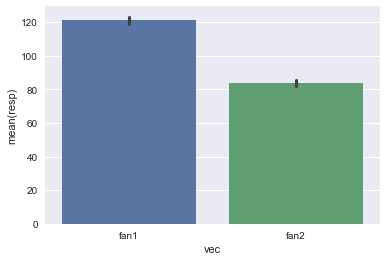

In [38]:
sns.barplot(x="vec", y="resp", data=acts)

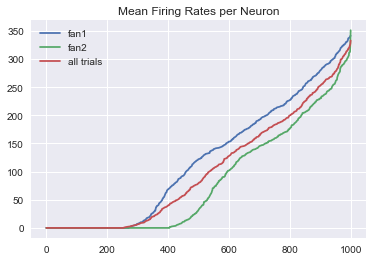

In [39]:
plt.title("Mean Firing Rates per Neuron")
plt.plot(np.sort(np.mean(activity_1, axis=0)), label="fan1")
plt.plot(np.sort(np.mean(activity_2, axis=0)), label="fan2")
plt.plot(np.sort(np.mean(np.concatenate((activity_1, activity_2)), axis=0)), label="all trials")
plt.legend()

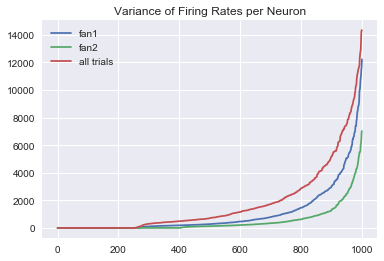

In [40]:
plt.title("Variance of Firing Rates per Neuron")
plt.plot(np.sort(np.var(activity_1, axis=0)), label="fan1")
plt.plot(np.sort(np.var(activity_2, axis=0)), label="fan2")
plt.plot(np.sort(np.var(np.concatenate((activity_1, activity_2)), axis=0)), label="all trials")
plt.legend()

Number of neurons basically firing for both vectors
255


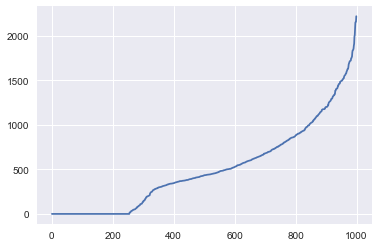

In [41]:
print("Number of neurons basically firing for both vectors")
fire_diff = np.sort(np.abs(np.sum(activity_1, axis=0) - np.sum(activity_2, axis=0)))
print(len(fire_diff[fire_diff < 10]))
plt.plot(fire_diff)

In [42]:
print("Number of neurons basically not firing for either vector")
fire_diff = np.sort(np.abs(np.sum(activity_1, axis=0) + np.sum(activity_2, axis=0)))
len(fire_diff[fire_diff < 10])

Number of neurons basically not firing for either vector


255